In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


In [4]:
# Adjust paths as necessary
path_to_train = 'sample_data/train.csv'

# Load the datasets
train_data = pd.read_csv(path_to_train)

# Prepare the data
X = train_data.drop('Transported', axis=1)
y = train_data['Transported'].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Display some of the training data
print(X_train.head())
print(y_train.head())

# Define columns
categorical_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Set up preprocessing for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean of the column
    ('scaler', StandardScaler()),                # Scale data to have mean=0 and variance=1
    ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Generate polynomial and interaction features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Replace missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Convert categorical data into dummy/indicator variables
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Initialize the model with a Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

# Create the pipeline with preprocessing and the model
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Setup grid search to explore different tree configurations
param_grid = {
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 10, 20],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_clf = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_clf.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_clf.best_params_)
print("Best score:", grid_clf.best_score_)


     PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
2333     2513_01      Earth     False       NaN  TRAPPIST-1e  28.0  False   
2589     2774_02      Earth     False   F/575/P  TRAPPIST-1e  17.0  False   
8302     8862_04     Europa      True   C/329/S  55 Cancri e  28.0  False   
8177     8736_02       Mars     False  F/1800/P  TRAPPIST-1e  20.0  False   
500      0539_02     Europa      True    C/18/P  55 Cancri e  36.0  False   

      RoomService  FoodCourt  ShoppingMall    Spa  VRDeck               Name  
2333          0.0       55.0           0.0  656.0     0.0     Loree Mathison  
2589          0.0     1195.0          31.0    0.0     0.0  Crisey Mcbriddley  
8302          0.0        0.0           0.0    0.0     0.0     Alramix Myling  
8177          NaN        2.0         289.0  976.0     0.0          Tros Pota  
500           0.0        0.0           0.0    0.0     0.0     Achyon Nalanet  
2333    0
2589    0
8302    1
8177    1
500     1
Name: Transpo

In [5]:
# Display best parameters and best score
print("Best parameters:", grid_clf.best_params_)
print("Best score:", grid_clf.best_score_)

Best parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best score: 0.7773961075568014


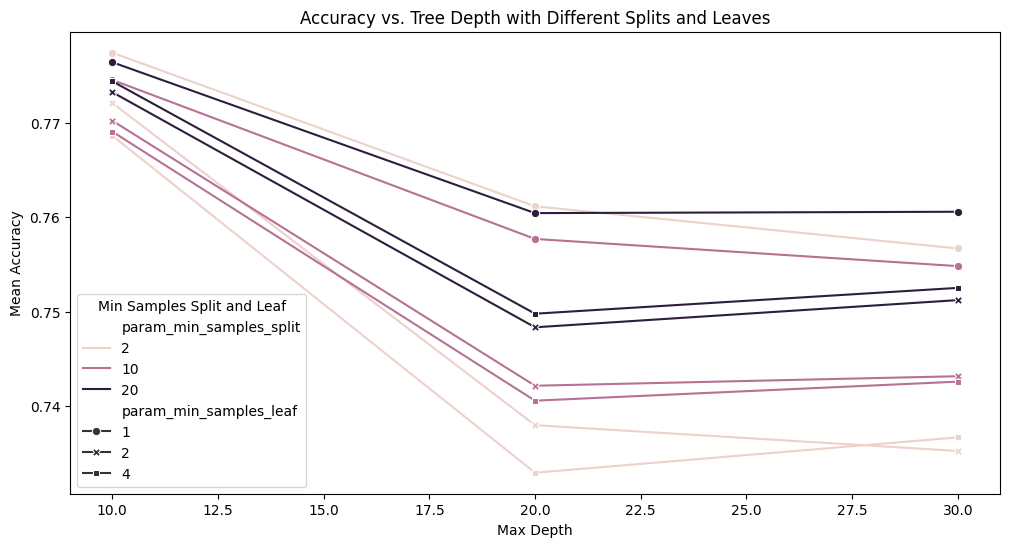

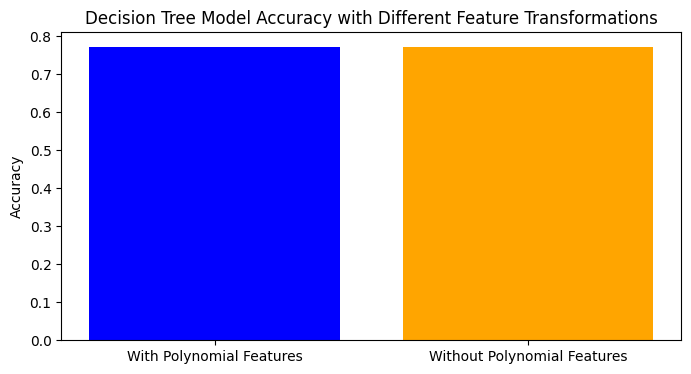

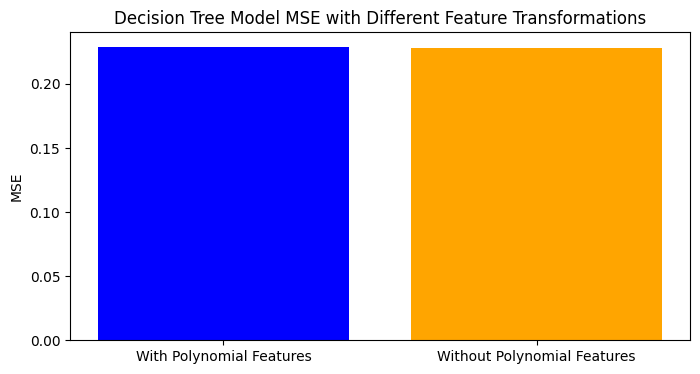

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Results from GridSearchCV
results = pd.DataFrame(grid_clf.cv_results_)
params = results['params']
results['param_max_depth'] = results['param_model__max_depth']
results['param_min_samples_split'] = results['param_model__min_samples_split']
results['param_min_samples_leaf'] = results['param_model__min_samples_leaf']

# Plotting accuracy for different configurations
plt.figure(figsize=(12, 6))
sns.lineplot(data=results, x='param_max_depth', y='mean_test_score', hue='param_min_samples_split', style='param_min_samples_leaf', markers=True, dashes=False)
plt.title('Accuracy vs. Tree Depth with Different Splits and Leaves')
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.legend(title='Min Samples Split and Leaf')
plt.show()

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Evaluate the best model from grid search
best_clf = grid_clf.best_estimator_
best_clf.fit(X_train, y_train)
preds = best_clf.predict(X_test)
accuracy_best = accuracy_score(y_test, preds)
mse_best = mean_squared_error(y_test, preds)

# Modify the pipeline to remove polynomial features transformation
numerical_transformer_no_poly = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
preprocessor_no_poly = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_no_poly, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)
clf_no_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_no_poly),
    ('model', DecisionTreeClassifier(random_state=42))
])

# Train and evaluate the model without polynomial features
clf_no_poly.fit(X_train, y_train)
preds_no_poly = clf_no_poly.predict(X_test)
accuracy_no_poly = accuracy_score(y_test, preds_no_poly)
mse_no_poly = mean_squared_error(y_test, preds_no_poly)

# Plotting accuracy comparison
plt.figure(figsize=(8, 4))
bar_positions = np.arange(2)
bar_heights = [accuracy_best, accuracy_no_poly]
plt.bar(bar_positions, bar_heights, color=['blue', 'orange'])
plt.xticks(bar_positions, ['With Polynomial Features', 'Without Polynomial Features'])
plt.ylabel('Accuracy')
plt.title('Decision Tree Model Accuracy with Different Feature Transformations')
plt.show()

# Plotting MSE comparison
plt.figure(figsize=(8, 4))
bar_heights = [mse_best, mse_no_poly]
plt.bar(bar_positions, bar_heights, color=['blue', 'orange'])
plt.xticks(bar_positions, ['With Polynomial Features', 'Without Polynomial Features'])
plt.ylabel('MSE')
plt.title('Decision Tree Model MSE with Different Feature Transformations')
plt.show()


Accuracy: 0.7711
Mean Squared Error: 0.2289


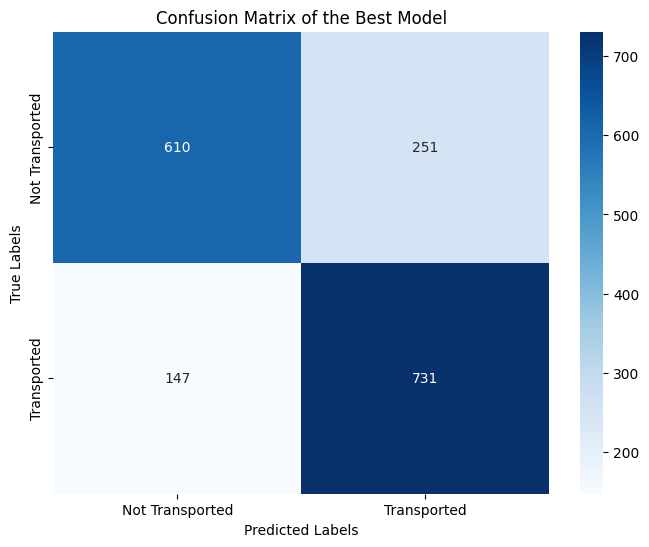

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using the best estimator from GridSearchCV
best_model = grid_clf.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.4f}")
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Transported', 'Transported'],
            yticklabels=['Not Transported', 'Transported'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of the Best Model')
plt.show()


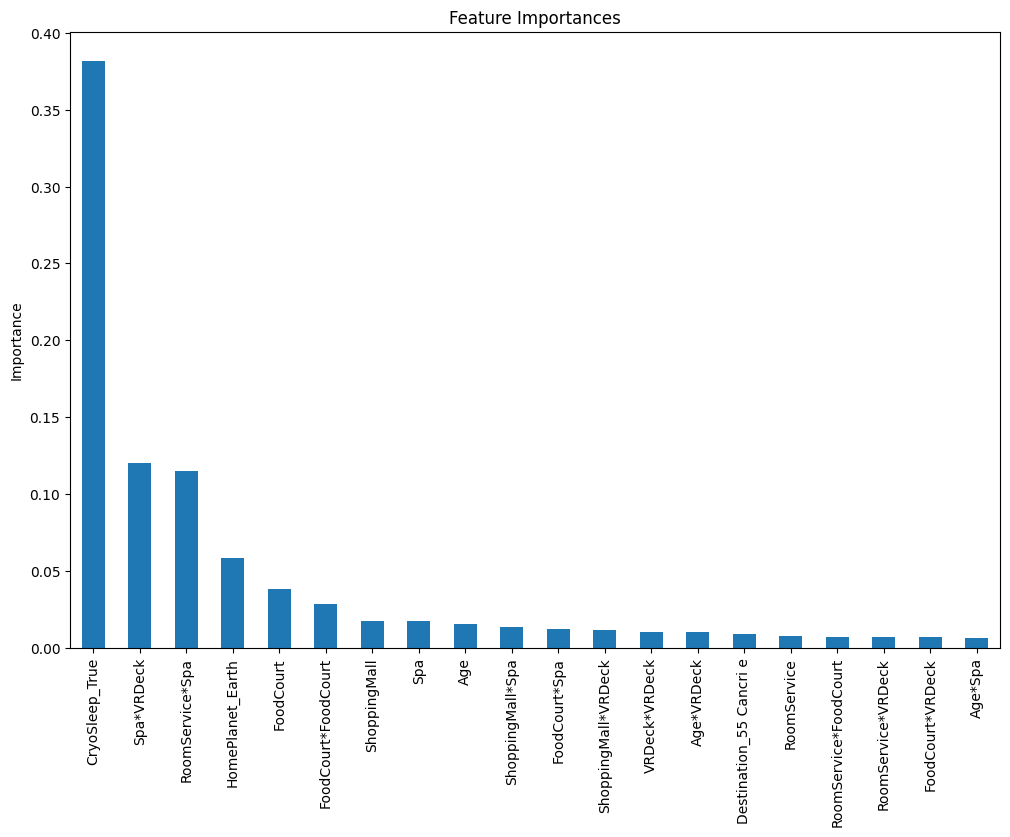

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

!pip install --upgrade scikit-learn
feature_names = list(best_clf.named_steps['preprocessor'].transformers_[0][1].named_steps['poly'].get_feature_names_out(numerical_cols)) + \
                list(best_clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))
from itertools import combinations_with_replacement

# Function to create polynomial feature names
def polynomial_feature_names(features, degree):
    def add_combinations(comb):
        return "*".join(comb)

    poly_features = []
    for d in range(1, degree+1):
        poly_features.extend([add_combinations(comb) for comb in combinations_with_replacement(features, d)])
    return poly_features

# Apply this function
poly_features = polynomial_feature_names(numerical_cols, 2)  # For degree 2 polynomial features

# Get categorical feature names after one-hot encoding
ohe_feature_names = list(best_clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

# Combine both lists
feature_names = poly_features + ohe_feature_names


best_clf = grid_clf.best_estimator_
best_clf.fit(X_train, y_train)  # Fit the model with the best parameters found

# Extract feature names after one-hot encoding
# feature_names = list(best_clf.named_steps['preprocessor'].transformers_[0][1].named_steps['poly'].get_feature_names(input_features=numerical_cols)) + \
#                 list(best_clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_cols))

# Feature importances
importances = best_clf.named_steps['model'].feature_importances_

# Plotting feature importances
fig, ax = plt.subplots(figsize=(12, 8))
feature_importances = pd.Series(importances, index=feature_names)
top_features = feature_importances.sort_values(ascending=False)[:20]  # top 20 features
top_features.plot(kind='bar')
ax.set_title('Feature Importances')
ax.set_ylabel('Importance')
plt.show()

In [16]:

# Extracting hyperparameters and test scores
results = pd.DataFrame(grid_clf.cv_results_)


results_table = results.loc[:, [
    'param_model__max_depth',
    'param_model__min_samples_split',
    'param_model__min_samples_leaf',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]]

# Rename the columns for readability
results_table.rename(columns={
    'param_model__max_depth': 'Max Depth',
    'param_model__min_samples_split': 'Min Samples Split',
    'param_model__min_samples_leaf': 'Min Samples Leaf',
    'mean_test_score': 'Mean Test Score',
    'std_test_score': 'STD Test Score',
    'rank_test_score': 'Rank'
}, inplace=True)

# Sort the results by the rank of the test score
results_table.sort_values('Rank', inplace=True)

results_table.to_csv('sample_data/results_table.csv', index=False)
print(results_table.head())  # To display just the top few rows


   Max Depth Min Samples Split Min Samples Leaf  Mean Test Score  \
9         10                 2                1         0.777396   
11        10                20                1         0.776389   
10        10                10                1         0.774520   
17        10                20                4         0.774375   
14        10                20                2         0.773224   

    STD Test Score  Rank  
9         0.008897     1  
11        0.007309     2  
10        0.009684     3  
17        0.009436     4  
14        0.005802     5  
